In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [17]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [18]:
data=pd.concat([train_data,test_data])
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [24]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [25]:
len(data)

12970

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [28]:
data['Transported'].value_counts()

3

In [29]:
len(data.dropna())

6606

In [43]:
data['Family']=data['PassengerId'].apply(lambda x:x.split('_')[0])

<Axes: >

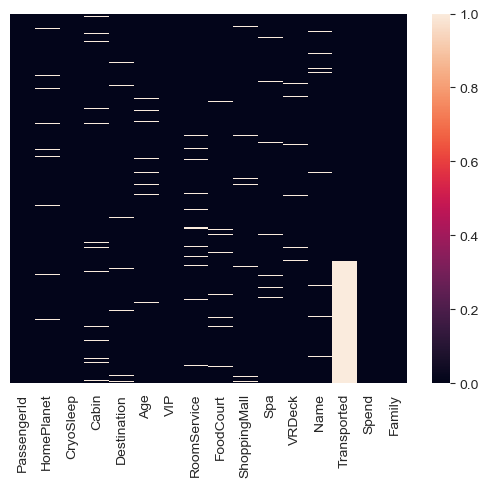

In [44]:
sns.heatmap(data.isnull(),yticklabels=False,cmap='rocket')

In [45]:
data.select_dtypes(include='number').columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Spend'],
      dtype='object')

In [46]:
print(data['HomePlanet'].unique())
print(data['Destination'].unique())

['Europa' 'Earth' 'Mars' nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


In [47]:
data['Spend']=data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [48]:
def fill_zero(x):
    if pd.isnull(x.iloc[1]):
        if x.iloc[0]==True:
            return 0
    else:
        return x.iloc[1]
def fill_cryo(x):
    if pd.isnull(x.iloc[0]):
        if x.iloc[1]==0:
            return True
        else:
            return False
    return x.iloc[0]

In [49]:
data['CryoSleep']=data[['CryoSleep','Spend']].apply(fill_cryo,axis=1)
data['CryoSleep']=data[['CryoSleep','FoodCourt']].apply(fill_cryo,axis=1)
data['CryoSleep']=data[['CryoSleep','RoomService']].apply(fill_cryo,axis=1)
data['VIP'].bfill(inplace=True)

In [50]:
def fill_home(x):
    if pd.isna(x.iloc[1]):
        temp_df=data[data['Family']==x.iloc[0]]
        if len(temp_df['HomePlanet'].dropna().unique())==0:
            return np.nan
        return temp_df['HomePlanet'].dropna().unique()[0]
    return x.iloc[1]
def fill_destination(x):
    if pd.isna(x.iloc[1]):
        temp_df=data[data['Family']==x.iloc[0]]
        if len(temp_df['Destination'].dropna().unique())==0:
            return np.nan
        return temp_df['Destination'].dropna().unique()[0]
    return x.iloc[1]

In [56]:
data['HomePlanet']=data[['Family','HomePlanet']].apply(fill_home,axis=1)
data['HomePlanet'].bfill(inplace=True)
data['Destination']=data[['Family','Destination']].apply(fill_destination,axis=1)
data['Destination'].bfill(inplace=True)
for i in data.select_dtypes(include='number').columns:
    if i=='Transported':
        continue
    if i=='Age':
        data[i].fillna(data.groupby(['VIP','HomePlanet'])[i].transform('mean'),inplace=True)
        continue
    data[i]=data[['CryoSleep',i]].apply(fill_zero,axis=1)
    data[i].fillna(data.groupby(['VIP','HomePlanet'])[i].transform('mean'),inplace=True)
data.groupby(['VIP','HomePlanet'])['Age'].mean()

VIP    HomePlanet
False  Earth         25.991118
       Europa        34.091185
       Mars          29.231510
True   Earth         47.000000
       Europa        37.223464
       Mars          34.967391
Name: Age, dtype: float64

In [ ]:
sum(data['HomePlanet']==data['Destination'])

In [57]:
def side(s):
    if pd.isnull(s):
        return s
    else:
        return s[-1]

In [58]:
def cabin(s):
    if pd.isnull(s):
        return s
    else:
        return s[0]

In [59]:
data['Deck']=data['Cabin'].apply(cabin)
data['Cabin']=data['Cabin'].apply(side)

In [60]:
data['Deck'].bfill(inplace=True)
data['Cabin'].bfill(inplace=True)
data.drop(['Name'],inplace=True,axis=1)

<Axes: >

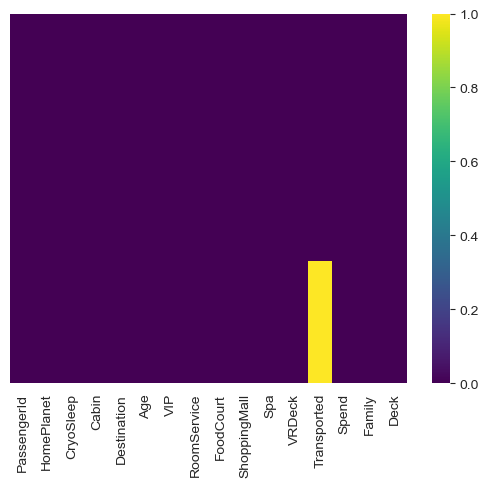

In [61]:
sns.heatmap(data.isnull(),yticklabels=False,cmap='viridis')

In [19]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Family', 'Spend', 'Deck'],
      dtype='object')

In [20]:
data.drop(['Spend'],axis=1,inplace=True)
data.drop(['Family'],axis=1,inplace=True)
data.to_csv('clean.csv')